<a href="https://colab.research.google.com/github/BasilSLyshkin/TInkoff_Lab_EDA/blob/main/Tinkoff_Lab_Eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Прогнозирование временных рядов
Импорт библиотек и первоначальная обработка данных:

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from scipy.stats.stats import spearmanr
from itertools import combinations
from collections import deque

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tinkoff Lab(доки)/lab_sample_train.csv',sep=';', decimal = ',')
df.rename(columns = {'feature_1_cur':'F1', 'feature_2_cur':'F2',
       'feature_3_cur':'F3', 'feature_4_cur':'F4', 'feature_5_3m':'F5', 'feature_6_cur':'F6',
       'feature_7_cur':'F7', 'feature_8_cur':'F8', 'feature_9_cur':'F9', 'feature_10_cur':'F10'}, inplace = True)
ind = pd.MultiIndex.from_tuples(list(zip(df.id, df.month_dt)))
df.set_index(ind, inplace = True)
df = df.sort_index()

Новые признаки:


*   'time' - порядковый номер месяца
*   'dynamics' - изменение глубины просрочки(0-глубина не изменилась, 1 - глубина уменьшилась, -1 - глубина увеличилась)



In [ ]:
df['time']=df.groupby(['id']).cumcount()
df['dynamics']=-df.ovd_category.diff()
df.loc[df.time==0,'dynamics']=np.nan

Заполним пропущенные значения средними величинами.

In [ ]:
new=df[['F3','F4','F5','F6','F7']]
df[['F3','F4','F5','F6','F7']]=new.fillna(new.mean())

count_del=df[['id','dynamics']][df.dynamics==-1].groupby(['id']).count()

In [ ]:
df.head()

id    month_dt  seg_flg  target        F1        F2        F3  \
1 2018-08-01   1  2018-08-01        0       0  0.008783  0.019969 -0.008545   
  2018-09-01   1  2018-09-01        0       0 -0.002618  0.019969 -0.008167   
  2018-10-01   1  2018-10-01        0       0  0.016878  0.019969 -0.011374   
  2018-11-01   1  2018-11-01        0       0 -0.003004  0.019969 -0.008327   
  2018-12-01   1  2018-12-01        0       0 -0.003052  0.019969 -0.008041   

                    F4        F5        F6        F7  F8  F9  F10  \
1 2018-08-01 -0.005779 -0.165199 -0.351351 -0.006996   1   0    0   
  2018-09-01 -1.180973 -0.435261 -0.001038 -0.006996   0   0    0   
  2018-10-01 -0.384924 -1.368201 -0.328750 -0.006996   1   0    0   
  2018-11-01  1.384685 -1.171792  0.021563 -0.006996   0   0    0   
  2018-12-01  1.384685 -0.877180  0.032864 -0.006996   0   0    0   

              new_samp_part_flg  feature_7_parts  ovd_category  time  dynamics  
1 2018-08-01                  0              NaN             1     0       NaN  
  2018-09-01                  0              NaN             0     1       1.0  
  2018-10-01                  0              NaN             1     2      -1.0  
  2018-11-01                  0              NaN             0     3       1.0  
  2018-12-01                  0              NaN             0     4      -0.0

## Разведочный анализ признаков
Распределение длительностей данных для каждого человека:

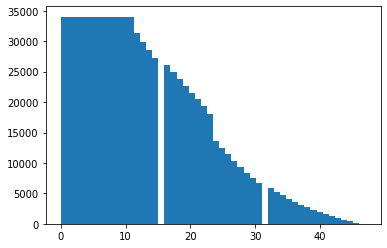

In [ ]:
plt.hist(df['time'], bins = 50);

In [ ]:
def draw_feat(feature, per = 1,xleft = -50, yleft = 50):
    plt.figure(figsize = (50,50))
    top = df.sample(frac = per, replace = False)
    for i in range(1,17):
        plt.subplot(4,4,i)
        plt.hist(top[top['time'] == i][feature], bins = 50, label = feature +' at time '+str(i))
        plt.yscale('log')
        #plt.xlim([xleft, yleft])
        plt.legend(loc=2, prop={'size': 16})

Со временем меняет распределение только первый признак:

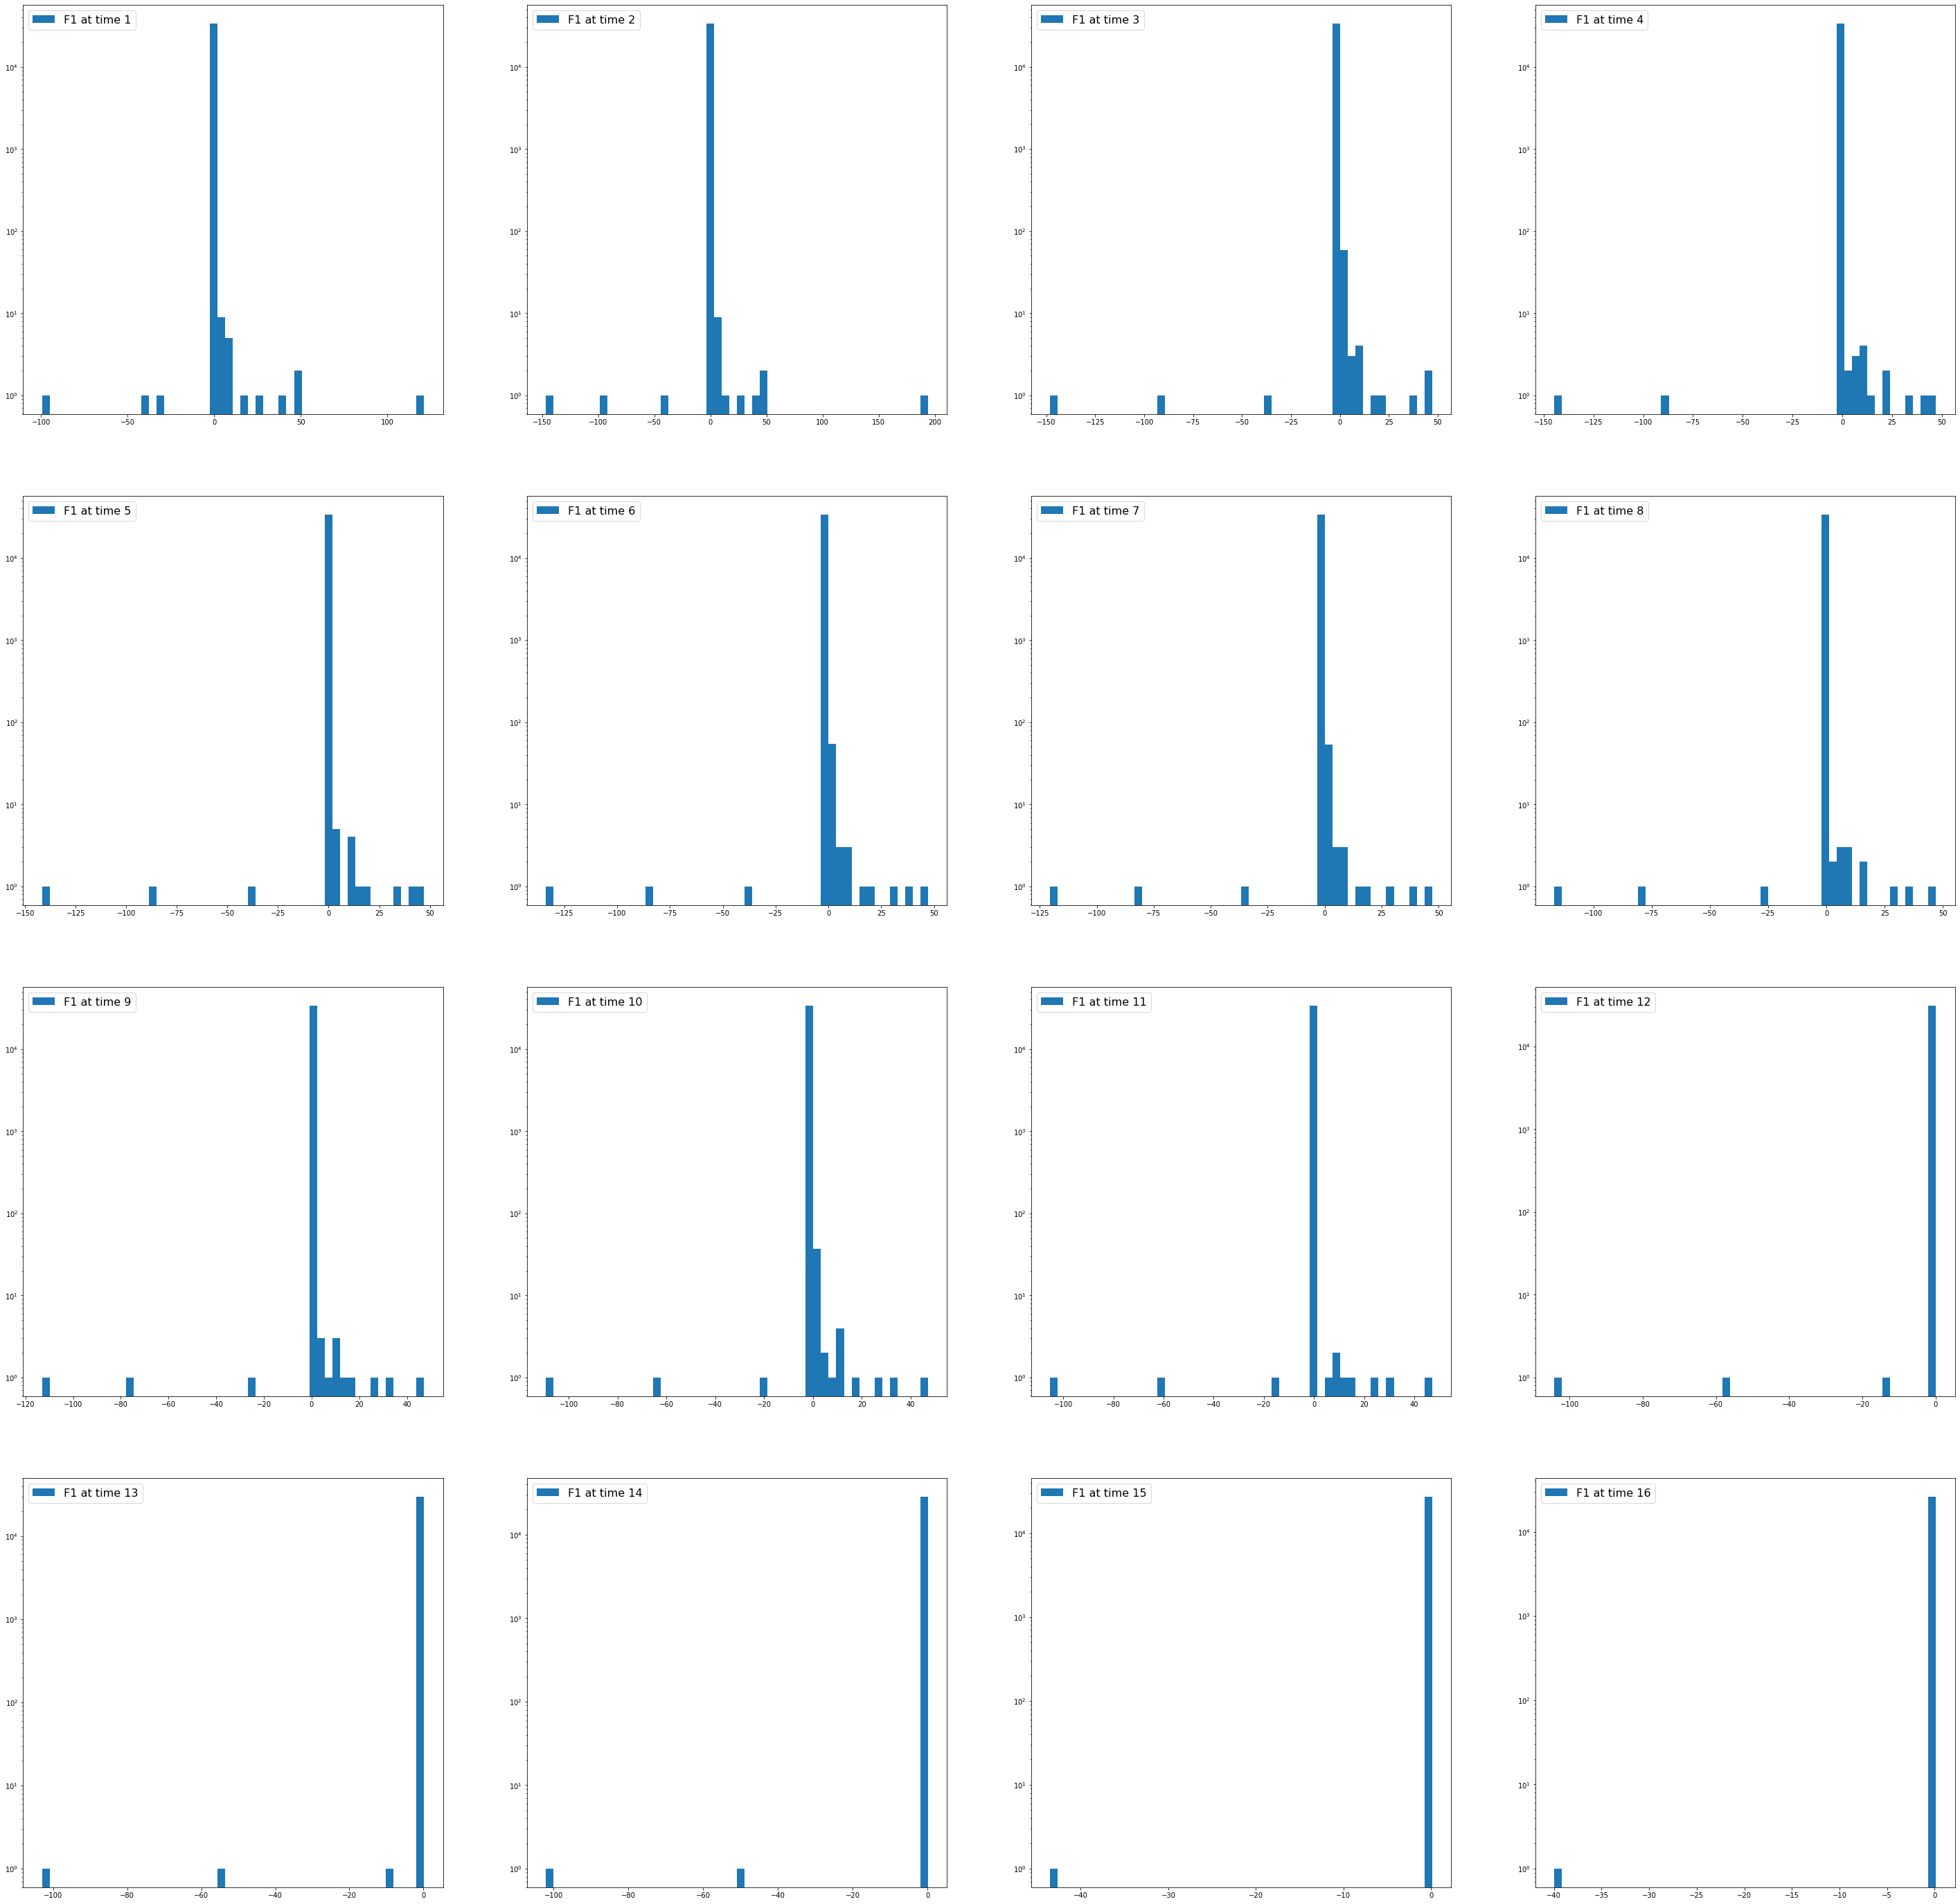

In [ ]:
draw_feat('F1')

Остальные признаки не меняют распределения с течением времени:

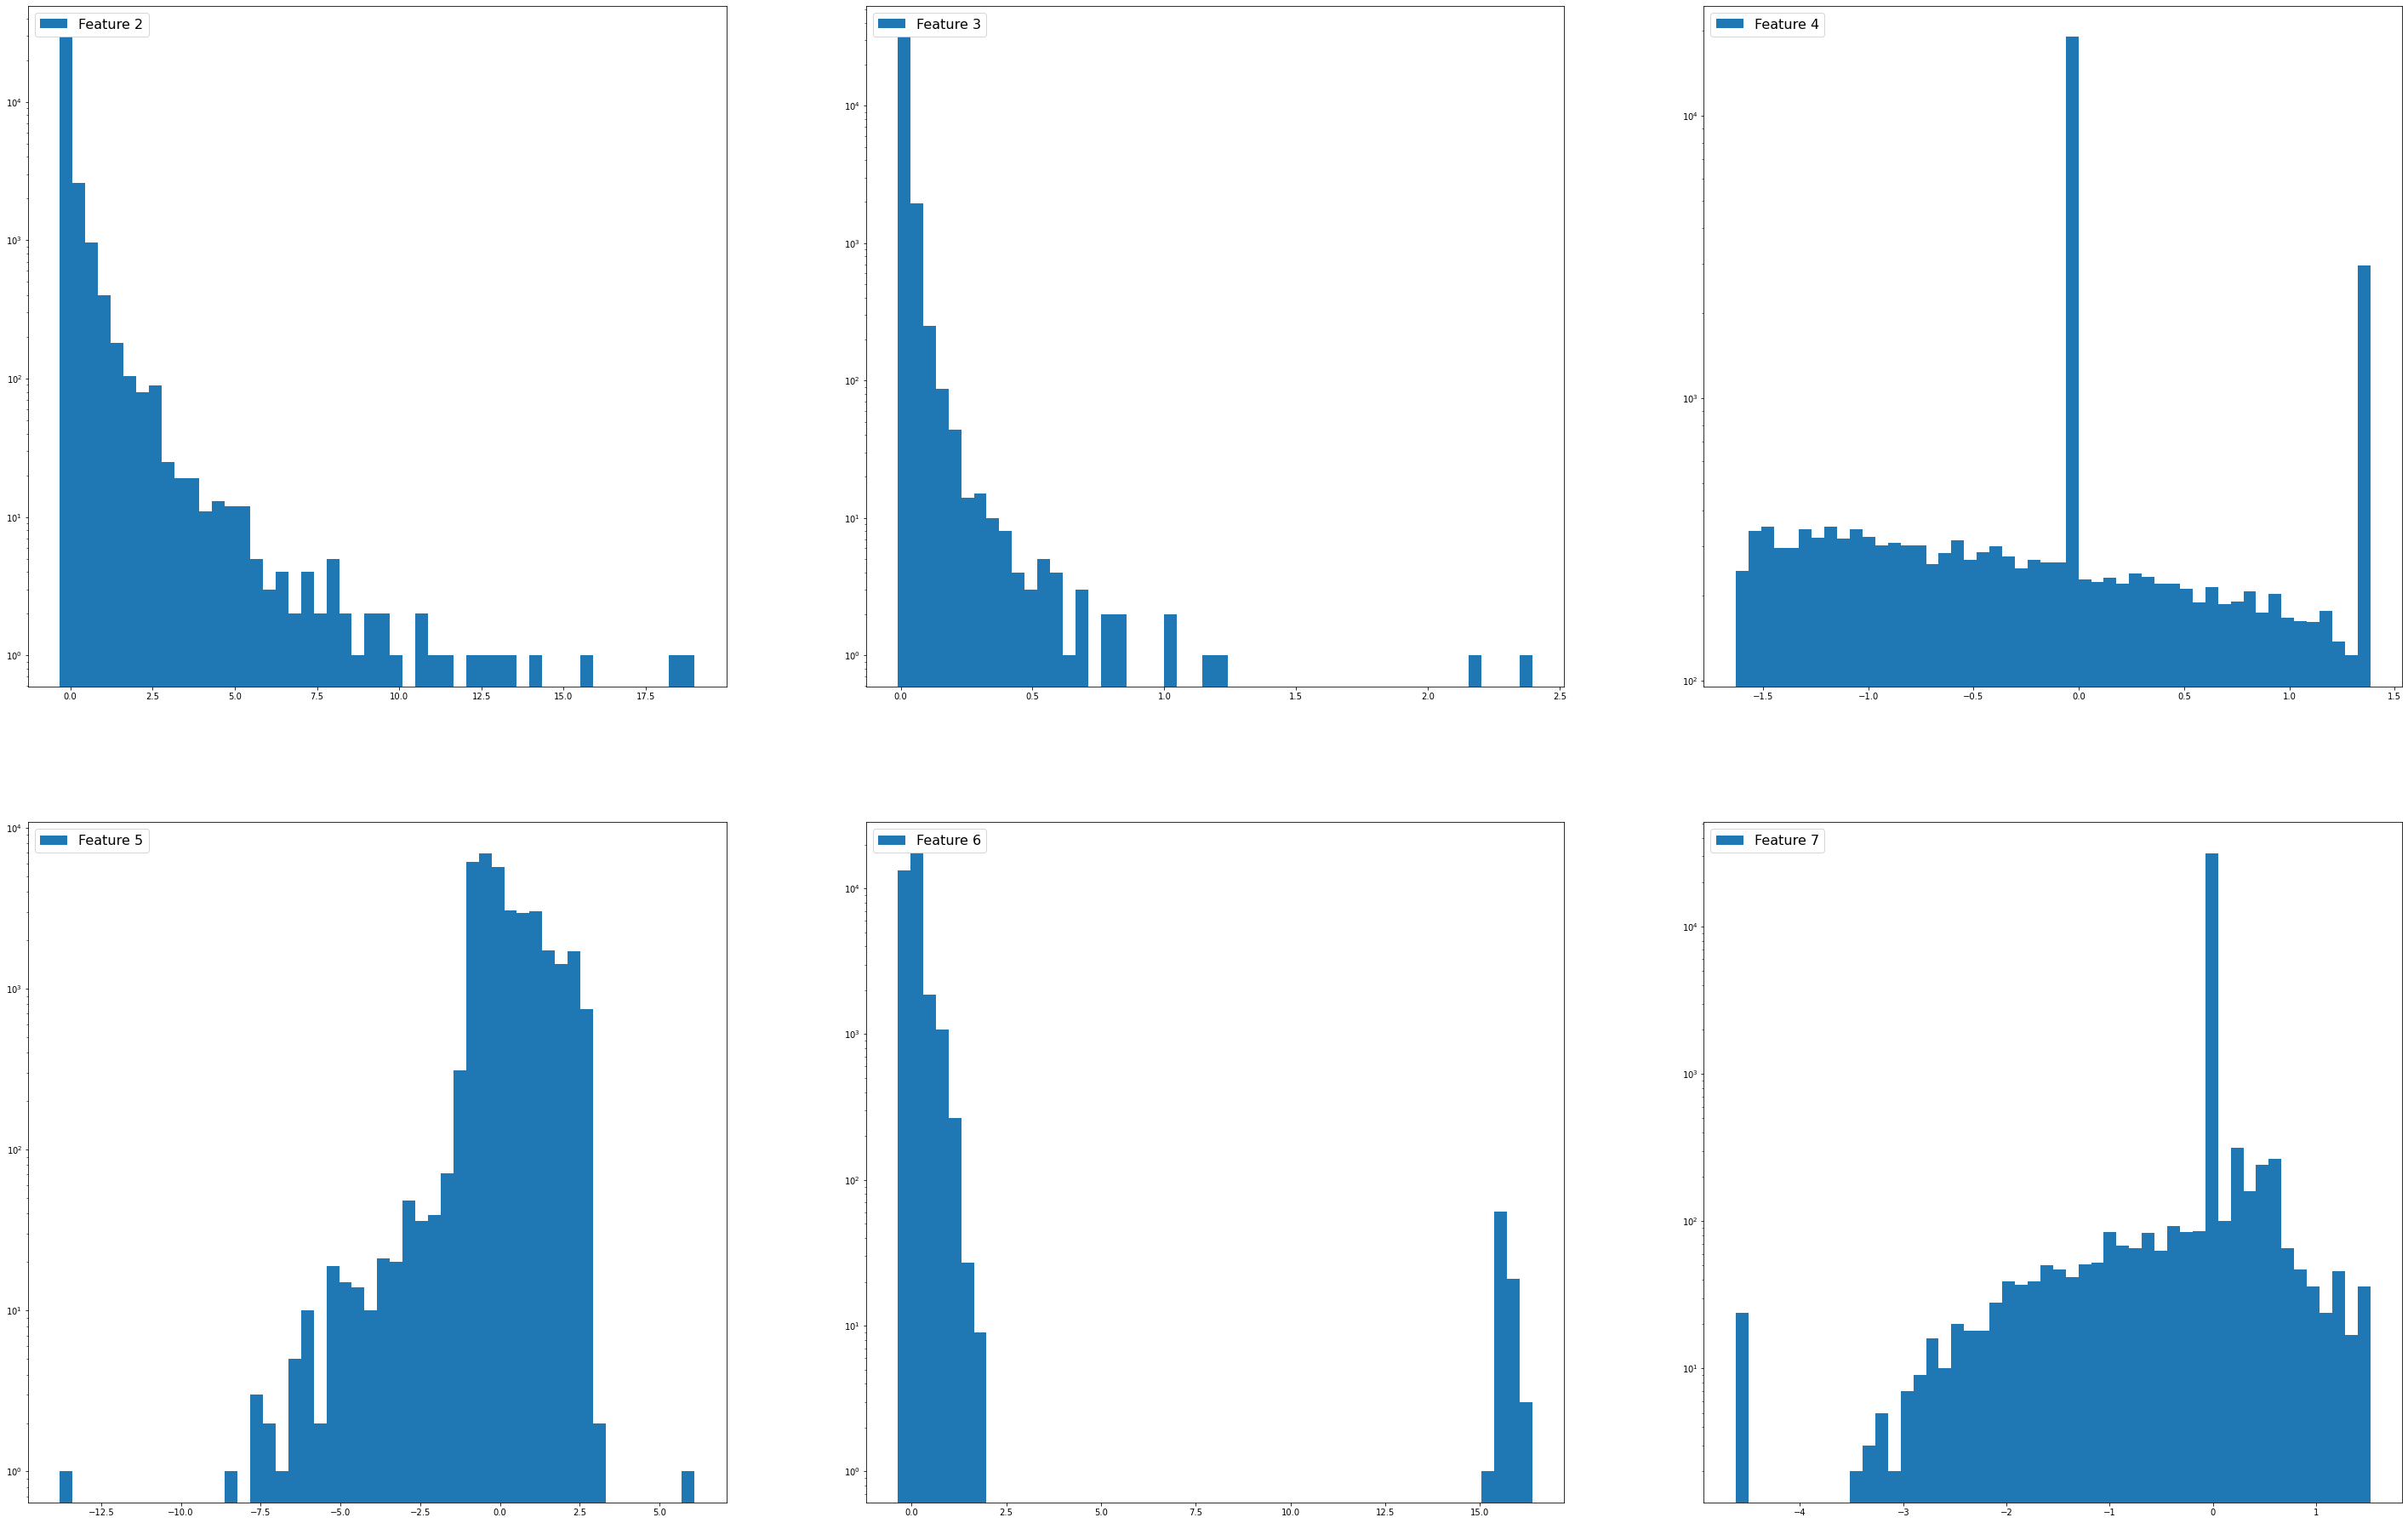

In [ ]:
plt.figure(figsize = (50,50))
for i in range(2,8):
    plt.subplot(3,3,i-1)
    plt.hist(df[df['time'] == 1]['F'+str(i)], bins = 50, label = 'Feature '+ str(i))
    plt.yscale('log')
    plt.legend(loc=2, prop={'size': 16})
plt.savefig('other.png')

В шестом признаке есть дефолтные заполнения. В будущем понадобиться смотреть на первые разности в каждой фиче, поэтому придется удалить всех id находящиеся в правом столбце.

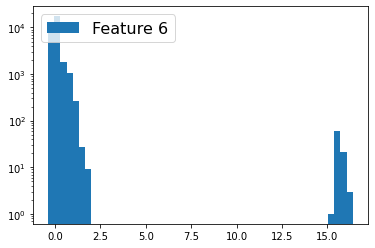

In [ ]:
plt.hist(df[df['time'] == 1]['F6'], bins = 50, label = 'Feature 6')
plt.yscale('log')
plt.legend(loc=2, prop={'size': 16})

In [ ]:
df = df[(df['F6'] <=10) | df['F6'].isna()]

## Графики собственных значений

In [ ]:
def draw_curves_seq(w,N,Features,S):
#w - window
#N - количество просрочек, по которому выравниваем
#S - число клиентов
  M = np.empty((S,100)) #матрица, в которой по строкам будут стоять выровненные lambda_max по каждому клиенту
  M[:] = np.nan
  ind = np.random.randint(len(count_del[count_del.dynamics>=N]), size=S) #индексы рандомной подвыборки из S клиентов, у которых >=N просрочек
  l = len(Features)
  for c, id in enumerate(count_del[count_del.dynamics >= N].index[ind]):

    client= df[df.id == id] #выбираем из таблицы наш id
    client.set_index('time', inplace = True)
    del_ind = client[client.dynamics == -1].index #массив с индексами просрочек
    diff_features = np.diff(client[Features].to_numpy(), axis=0) #первые разности выбранных фичей
    y = np.zeros((100,)) #сюда запишем lambda_max для выбранного id
    y[:] = np.nan

    for t in range(len(diff_features) - w + 1):

      Mat = np.zeros(shape = (l,l))
      for i in range(l):
        for j in range(l):

          if pd.isnull(spearmanr(diff_features[t:t+w,i],diff_features[t:t+w,j])[0]) == False:
            Mat[i,j]=spearmanr(diff_features[t:t+w,i],diff_features[t:t+w,j])[0] #заполняем матрицу к-тами спирмана
            
      y[50-del_ind[N-1]+t] = np.linalg.eig(Mat)[0].max() #записываем в y, такой индекс для выравнивания (получится, что ровно в 50 N-ая по счету просрочка)

    Y=y[np.isnan(y)==False] #массив с lambda_max без выравнивания
    mov_ave=pd.DataFrame(Y).rolling(3).mean().to_numpy().reshape(-1)
    prev=(Y/mov_ave-1)*100 #превышение предыдущих 3 значений в процентах
    '''
    print(prev)
    print(np.argsort(prev),np.argsort(prev)[-6:-3])
    print(del_ind)
    '''
    M[c,:]=y
    X=np.arange(100)

    plt.plot(X, y, color='blue')
    plt.title(str(Features) + ', окно длины ' + str(w) + ', выравнивание по '+ str(N) +' просрочке')
  
  #тут считаем и рисуем среднее
  mean=np.nanmean(M, axis=0)
  mean=np.where(np.invert(np.isnan(M)).sum(axis=0)>=0.3*S,mean,np.nan)
  plt.plot(X, mean, color='black',linewidth=5) 

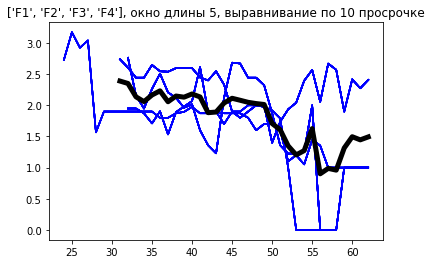

In [ ]:
warnings.filterwarnings("ignore")
draw_curves_seq(5,10,['F1','F2','F3','F4'],50)